In [1]:
import torch
#import torch.nn as nn
#import torch.nn.functional as F
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):    
        # c2 c3由于特性是2元组，kwargs可以给父类传递额外参数
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)    #stride默认与kernel_size相同
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    def forward(self, x):
        y1 = F.relu(self.p1_1(x))
        y2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        y3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        y4 = F.relu(self.p4_2(self.p4_1(x)))   #maxpool不用
        return torch.cat((y1, y2, y3, y4), dim=1)

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
)

In [4]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [5]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  
)

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [9]:
# shape test
x1 = torch.randn((1, 1, 96, 96))
for layer in net:
    x1 = layer(x1)
    print(x1.shape)

torch.Size([1, 64, 24, 24])
torch.Size([1, 192, 12, 12])
torch.Size([1, 480, 6, 6])
torch.Size([1, 832, 3, 3])
torch.Size([1, 1024])
torch.Size([1, 10])


loss 0.237, train acc 0.910, test acc 0.885
2513.0 examples/sec on cuda:0


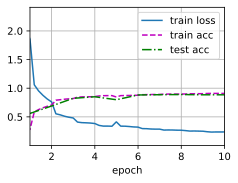

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

## 一些别的东西

In [11]:
# nn.MaxPool2d的stride默认与kernel_size相同，必须显式指定
x = torch.randn([1, 3, 3])
b = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
c = nn.MaxPool2d(kernel_size=3, padding=1)
x, b(x), c(x)

(tensor([[[-0.3717,  0.4476, -0.1474],
          [-0.3347, -0.9348,  0.4703],
          [ 2.1558,  0.7793, -0.4631]]]),
 tensor([[[0.4476, 0.4703, 0.4703],
          [2.1558, 2.1558, 0.7793],
          [2.1558, 2.1558, 0.7793]]]),
 tensor([[[0.4476]]]))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

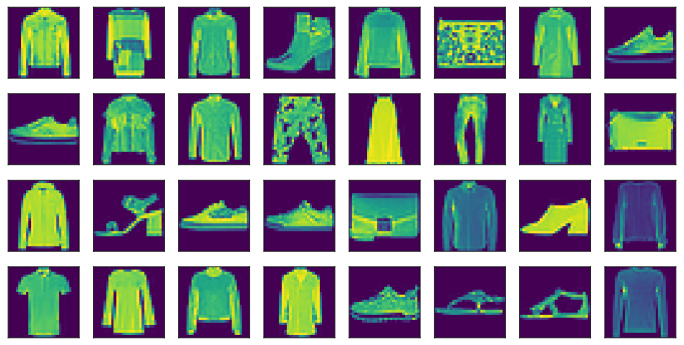

In [12]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
a = next(iter(train_iter))
b = a[0].reshape([128, 28, 28])
d2l.show_images(b, 4, 8)